In [1]:
import pandas as pd

from Chord import Chord
from Rule import Rule
from collections import defaultdict
import pitchtypes as pt
from probabilistic_model import ProbabilisticModel
from itertools import product
import torch 
from Environment import Environment
from Helpers import get_possible_intervals, get_qualities, get_possible_rhs_from_str, get_applicable_rules, evaluate_tree_from_dict
from TreeNode import TreeNode
from DQN import train_on_batch, ReplayBuffer, train_model, DQN, DQNWithTransformer
import numpy as np
from sklearn.model_selection import train_test_split

import random

In [20]:
import pickle

# Load the model from the file
with open('dqn_model2.pkl', 'rb') as file:
    unpickled_model = pickle.load(file)

print("Model has been successfully unpickled.")

Model has been successfully unpickled.


In [2]:
data = pd.read_json('../eda/JazzHarmonyTreebank/treebank.json')
trees_data = data[data['trees'].notna()]['trees']
ccts = [x[0]['complete_constituent_tree'] for x in list(trees_data)]
tree_chord_data = list(data[data['trees'].notna()]['chords'])

In [3]:
p_model = ProbabilisticModel()
p_model.fit(ccts)

In [4]:
prob_dict = p_model.prob_dict
rules = [Rule.unhash(i) for i in prob_dict.keys()]
chords_dataset = list(data['chords'])
# chords_dataset = [chord for chord in chords_dataset if len(chord) <= 20]  

In [5]:
model = DQN(1440, 20, hidden_dim=1024)

In [56]:
full_data = tree_chord_data.copy()
full_data.extend(random.sample(chords_dataset,150))

In [6]:

train_data, test_data = train_test_split(tree_chord_data, test_size=0.2, random_state=42)

In [7]:
train_model(model,train_data, prob_dict, rules, num_episodes=20000)

Episode 10 complete | Last loss: 1.7548
Episode 20 complete | Last loss: 3.7000
Episode 30 complete | Last loss: 3.7994
Episode 40 complete | Last loss: 2.8334
Episode 50 complete | Last loss: 2.6760
Episode 60 complete | Last loss: 4.4818
Episode 70 complete | Last loss: 3.0771
Episode 80 complete | Last loss: 3.7264
Episode 90 complete | Last loss: 4.4448
Episode 100 complete | Last loss: 4.0078
Episode 110 complete | Last loss: 2.6617
Episode 120 complete | Last loss: 2.5148
Episode 130 complete | Last loss: 2.6852
Episode 140 complete | Last loss: 2.0335
Episode 150 complete | Last loss: 2.7268
Episode 160 complete | Last loss: 4.4877
Episode 170 complete | Last loss: 5.6180
Episode 180 complete | Last loss: 2.5643
Episode 190 complete | Last loss: 4.7812
Episode 200 complete | Last loss: 3.8575
Episode 210 complete | Last loss: 3.8705
Episode 220 complete | Last loss: 3.3372
Episode 230 complete | Last loss: 3.0945
Episode 240 complete | Last loss: 3.0226
Episode 250 complete | La

In [9]:
import random
import numpy as np
from Chord import Chord
from TreeNode import TreeNode, create_parent_node, get_top_level_nodes
from Helpers import get_possible_intervals, get_qualities, get_possible_rhs_from_str, get_applicable_rules
from Rule import Rule
from Chord import Chord
from TreeNode import TreeNode, create_parent_node, get_top_level_nodes
import torch

class Environment:

    MAX_ACTIONS = 20
    MAX_CHORDS = 20

    def __init__(self, chord_sequence, rules, prob_dict):
        self.initial_sequence = chord_sequence
        self.current_state = chord_sequence.copy()
        self.current_nodes = [TreeNode(Chord(chord)) for chord in chord_sequence]
        self.rules = rules
        self.prob_dict = prob_dict
        self.actions = self.get_actions()
        self.applied_rules = []
        
    # Each index of rhs are a list of applicable rules to currentstate and currentstate + 1
    def get_actions(self):
        rhs_list = []

        for i in range(len(self.current_state) - 1):
            chord1 = Chord(self.current_state[i])
            chord2 = Chord(self.current_state[i + 1])
            possible_rhs = get_possible_rhs_from_str(chord1, chord2)
            rhs_list.append(get_applicable_rules(possible_rhs, self.rules))


        return rhs_list
    
    def concat_state_and_actions(self, chords_tensor, actions_tensor):
        # Concatenate along the last dimension
        return torch.cat((chords_tensor.reshape(-1), actions_tensor.squeeze(0).reshape(-1)), dim=-1)


    def build_action_index_map(self):

        index_map = []
        for i, rule_list in enumerate(self.get_actions()):
            for j, _ in enumerate(rule_list):
                index_map.append((i, j))
        return index_map

    def apply_rule_index(self,rule_index_i,rule_index_j):
        rule = self.actions[rule_index_i][rule_index_j]
        node1 = self.current_nodes[rule_index_i]
        node2 = self.current_nodes[rule_index_i + 1]
        nodes = [node1,node2]
        parent_root_index = rule.child_intervals.index('0') 
        parent = create_parent_node(node1, node2, nodes[parent_root_index], rule.lhs())
        self.current_nodes[rule_index_i] = parent
        self.current_nodes.pop(rule_index_i + 1)
        self.applied_rules.append(rule)
        self.current_nodes = get_top_level_nodes(self.current_nodes)
        self.current_state = [node.chord.label for node in self.current_nodes]
        self.actions = self.get_actions()

    def apply_rule(self, rule, node1, node2):
        nodes = [node1,node2]
        parent_root_index = rule.child_intervals.index('0') 
        parent = create_parent_node(node1, node2, nodes[parent_root_index], rule.lhs())

        self.current_nodes.append(parent)
        self.applied_rules.append(rule)

        self.current_nodes = get_top_level_nodes(self.current_nodes)
        self.current_state = [node.chord.label for node in self.current_nodes]
        self.actions = self.get_actions()

    def get_state_tensor2(self):
        QUALITY_VOCAB = ['major', 'minor', 'sus', 'unknown']
        INTERVAL_VOCAB = [str(i) for i in range(0,12)]

        def one_hot_encode(value, vocab):
            vec = [0] * len(vocab)
            idx = vocab.index(value if value in vocab else vocab.index('Other'))
            vec[idx] = 1
            return vec

        def encode_rule(rule):
            parent_vec = one_hot_encode(rule.parent_quality, QUALITY_VOCAB)

            interval1_vec = one_hot_encode(rule.child_intervals[0], INTERVAL_VOCAB)
            quality1_vec = one_hot_encode(rule.child_qualities[0], QUALITY_VOCAB)

            interval2_vec = one_hot_encode(rule.child_intervals[1], INTERVAL_VOCAB)
            quality2_vec = one_hot_encode(rule.child_qualities[1], QUALITY_VOCAB)

            return parent_vec + interval1_vec + quality1_vec + interval2_vec + quality2_vec

        chord_vector = []
        for chord in self.current_state[:self.MAX_CHORDS]:
            chord_vector.append(Chord.encode_chord(chord))

        # Pad if needed
        while len(chord_vector) < self.MAX_CHORDS:
            chord_vector.append([0] * len(chord_vector[0]))

        flat_chord_vector = [val for chord in chord_vector for val in chord]
        # chord_tensor = torch.tensor(flat_chord_vector, dtype=torch.float32).unsqueeze(0)

        actions = self.get_actions()
        action_vector = []

        count = 0
        for i in range(len(actions)):
            for j in range(len(actions[i])):
                if count >= self.MAX_ACTIONS:
                    break
                action_vector.append(encode_rule(actions[i][j]))
                count += 1
            if count >= self.MAX_ACTIONS:
                break
        
        flat_action_vector = [val for action in action_vector for val in action]

        return torch.tensor(flat_chord_vector + flat_action_vector, dtype=torch.float32)
        # rule_dim = len(action_vector[0]) if action_vector else 0
        # while len(action_vector) < self.MAX_ACTIONS:
        #     action_vector.append([0] * rule_dim)

        # actions_tensor = torch.tensor(action_vector, dtype=torch.float32).unsqueeze(0)
        # return chord_tensor, actions_tensor


    def get_state_tensor(self):
        QUALITY_VOCAB = ['major', 'minor', 'sus', 'unknown']
        INTERVAL_VOCAB = [str(i) for i in range(0,12)]

        def one_hot_encode(value, vocab):
            vec = [0] * len(vocab)
            idx = vocab.index(value if value in vocab else vocab.index('Other'))
            vec[idx] = 1
            return vec

        def encode_rule(rule):
            parent_vec = one_hot_encode(rule.parent_quality, QUALITY_VOCAB)

            interval1_vec = one_hot_encode(rule.child_intervals[0], INTERVAL_VOCAB)
            quality1_vec = one_hot_encode(rule.child_qualities[0], QUALITY_VOCAB)

            interval2_vec = one_hot_encode(rule.child_intervals[1], INTERVAL_VOCAB)
            quality2_vec = one_hot_encode(rule.child_qualities[1], QUALITY_VOCAB)

            return parent_vec + interval1_vec + quality1_vec + interval2_vec + quality2_vec

        chord_vector = []
        for chord in self.current_state[:self.MAX_CHORDS]:
            chord_vector.append(Chord.encode_chord(chord))
            distance_vec = []
            for other_chord in self.current_state[:self.MAX_CHORDS]:
                distance = Chord(chord).distance_to(Chord(other_chord))
                distance_vec.append(distance)
            while len(distance_vec) < self.MAX_CHORDS:
                distance_vec.append(-1)
            chord_vector[-1].extend(distance_vec)
        # Pad if needed
        while len(chord_vector) < self.MAX_CHORDS:
            chord_vector.append([0] * len(chord_vector[0]))

        flat_chord_vector = [val for chord in chord_vector for val in chord]
        chord_tensor = torch.tensor(flat_chord_vector, dtype=torch.float32).unsqueeze(0)

        actions = self.actions
        action_vector = []

        count = 0
        for i in range(len(actions)):
            for j in range(len(actions[i])):
                if count >= self.MAX_ACTIONS:
                    break
                action_vector.append(encode_rule(actions[i][j]))
                count += 1
            if count >= self.MAX_ACTIONS:
                break

        rule_dim = len(action_vector[0]) if action_vector else 0
        while len(action_vector) < self.MAX_ACTIONS:
            action_vector.append([0] * rule_dim)

        actions_tensor = torch.tensor(action_vector, dtype=torch.float32).unsqueeze(0)
        return chord_tensor, actions_tensor

    def step_nn(self):
        chord_tensor, actions_tensor = self.get_state_tensor()
        model_input = self.concat_state_and_actions(chord_tensor, actions_tensor)
        results = self.model.forward(model_input)
        index_map = self.build_action_index_map()[0:self.MAX_ACTIONS]
        # print(len(index_map))
        if len(index_map) == 0:
            return None  # no actions possible
        
        q_values = self.model(model_input).detach().squeeze(0)[0:len(index_map)]  # shape: (num_actions,)
        flat_index = q_values.squeeze(0).argmax().item()

        # reward_before = self.evaluate_tree()
        i, j = index_map[flat_index]
        reward_before = self.evaluate_tree()
        self.apply_rule_index(i, j)
        reward_after = self.evaluate_tree()
        # reward_after = self.evaluate_tree()
        last_rule = self.applied_rules[-1]
        # reward = prob_dict.get(last_rule.make_hashable(), 1e-10)  # Use same small value as in evaluate_tree
        # delta_reward = reward_after - reward_before
        next_chord_tensor, next_actions_tensor = self.get_state_tensor()
        # reward = self.evaluate_tree() if self.is_terminal() else np.log(prob_dict.get(last_rule.make_hashable(), 1e-10))
        reward = self.evaluate_tree() if self.is_terminal() else np.log(self.prob_dict.get(last_rule.make_hashable(), 1e-10))
        # reward = reward_after - reward_before
        done = self.is_terminal()
        self.actions = self.get_actions()
        # if done:
        #     delta_reward = self.evaluate_tree()
        return {
        "state": chord_tensor,
        "actions": actions_tensor,
        "action_index": flat_index,
        "reward": reward,
        "next_state": next_chord_tensor,
        "next_actions": next_actions_tensor,
        "done": done
    }
    def step(self, epsilon=0.1):
        chord_tensor, actions_tensor = self.get_state_tensor()
        model_input = self.concat_state_and_actions(chord_tensor, actions_tensor)
        results = self.model.forward(model_input)
        index_map = self.build_action_index_map()[0:self.MAX_ACTIONS]
        # print(len(index_map))
        if len(index_map) == 0:
            return None  # no actions possible
        
        if random.random() < epsilon:
            flat_index = random.randint(0, len(index_map) - 1)
        else:
            q_values = self.model(model_input).detach().squeeze(0)[0:len(index_map)]  # shape: (num_actions,)
            flat_index = q_values.squeeze(0).argmax().item()

        # reward_before = self.evaluate_tree()
        i, j = index_map[flat_index]
        reward_before = self.evaluate_tree()
        self.apply_rule_index(i, j)
        reward_after = self.evaluate_tree()
        # reward_after = self.evaluate_tree()
        last_rule = self.applied_rules[-1]
        # reward = prob_dict.get(last_rule.make_hashable(), 1e-10)  # Use same small value as in evaluate_tree
        # delta_reward = reward_after - reward_before
        next_chord_tensor, next_actions_tensor = self.get_state_tensor()
        # reward = self.evaluate_tree() if self.is_terminal() else np.log(prob_dict.get(last_rule.make_hashable(), 1e-10))
        reward = self.evaluate_tree() if self.is_terminal() else np.log(self.prob_dict.get(last_rule.make_hashable(), 1e-10))
        # reward = reward_after - reward_before
        done = self.is_terminal()
        self.actions = self.get_actions()
        # if done:
        #     delta_reward = self.evaluate_tree()
        return {
        "state": chord_tensor,
        "actions": actions_tensor,
        "action_index": flat_index,
        "reward": reward,
        "next_state": next_chord_tensor,
        "next_actions": next_actions_tensor,
        "done": done
    }
    

    def nn_simulate(self, epsilon=0.1):
        while not self.is_terminal():
            result = self.step_nn()
            if result is None:
                break
 

    def add_model(self, model):
        self.model = model

    def is_terminal(self):
        return len(self.current_state) == 1

    def random_baseline_step(self):
        chord_tensor, actions_tensor = self.get_state_tensor()
        index_map = self.build_action_index_map()

        if len(index_map) == 0:
            return None
        flat_index = random.randint(0, len(index_map) - 1)
        i, j = index_map[flat_index]                
        self.apply_rule_index(i, j)

    def simulate_random_baseline(self):
        while not self.is_terminal():
            self.random_baseline_step()

    def simulate_greedy_baseline(self):
        while not self.is_terminal():
            actions = self.get_actions()
            index_map = self.build_action_index_map()
            max_prob = float('-inf')
            max_i = 0
            max_j = 0
            for i, rule_list in enumerate(actions):
                for j, rule in enumerate(rule_list):
                    prob = self.prob_dict.get(rule.make_hashable(), 1e-10)  # Use same small value as in evaluate_tree
                    if prob > max_prob:
                        max_prob = prob
                        max_i = i
                        max_j = j
            if len(index_map) == 0:
                break
            self.apply_rule_index(max_i, max_j)

    def evaluate_tree(self):
        log_probs = 0
        for rule in self.applied_rules:
            log_probs += np.log(self.prob_dict.get(rule.make_hashable(), 1e-10))  # Add a small value to avoid log(0)

        return log_probs 



In [7]:
test_env = Environment(chords_dataset[3], rules, prob_dict)
test_env.add_model(unpickled_model)
test_env.nn_simulate()
test_env.evaluate_tree()

-19.33794701692768

In [8]:
greedy_env = Environment(chords_dataset[3], rules, prob_dict)
greedy_env.simulate_greedy_baseline()
greedy_env.evaluate_tree()

-16.212803669722184

In [8]:
ccts_test = []
for i in test_data:
    tree = data[(data['trees'].notna()) & (data['chords'].apply(lambda x: x == i))]['trees']
    if not tree.empty:
        ccts_test.append(evaluate_tree_from_dict(list(tree)[0][0]['complete_constituent_tree'], prob_dict)[1])
    else:
        print(f"No tree found for chords: {i}")

In [ ]:
import pickle

# Save the model to a file
with open('dqn_model3.pkl', 'wb') as file:
    pickle.dump(model, file)

print("Model has been pickled and saved as 'dqn_model.pkl'.")

Model has been pickled and saved as 'dqn_model.pkl'.


In [9]:
greedy = []
random_vals = []
nn_vals = []
counter = 0
for chord in test_data:
    counter += 1
    env = Environment(chord, rules, prob_dict)
    env.add_model(model)
    env.simulate_random_baseline()

    random_vals.append(env.evaluate_tree())
    env = Environment(chord, rules, prob_dict)
    env.simulate_greedy_baseline()
    greedy.append(env.evaluate_tree())
    
    env = Environment(chord, rules, prob_dict)
    env.add_model(model)
    env.nn_simulate()
    nn_vals.append(env.evaluate_tree())
    

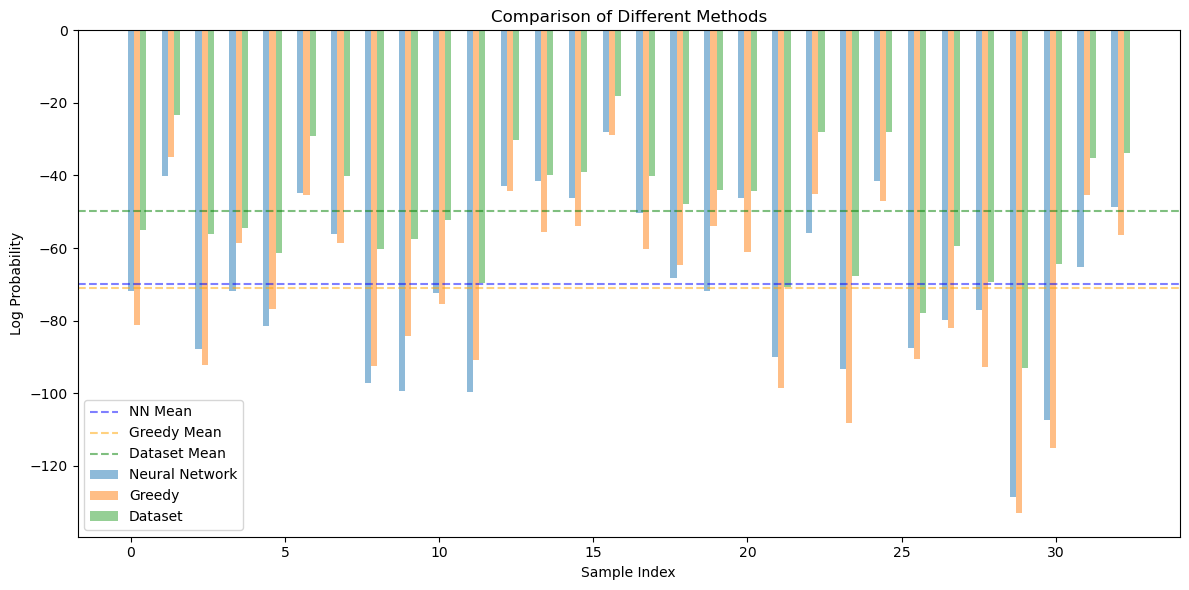

In [12]:
import numpy as np

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Define the width of each bar and the spacing between groups
bar_width = 0.2
group_spacing = 0.5

# Calculate the x positions for each group
x = np.arange(len(nn_vals)) * (3 * bar_width + group_spacing)

# Plot the bars for each method
plt.bar(x, nn_vals, alpha=0.5, label='Neural Network', width=bar_width)
plt.bar(x + bar_width, greedy, alpha=0.5, label='Greedy', width=bar_width)
plt.bar(x + 2 * bar_width, ccts_test, alpha=0.5, label='Dataset', width=bar_width)

# Add labels and title
plt.xlabel('Sample Index')
plt.ylabel('Log Probability')
plt.title('Comparison of Different Methods')

# Add mean lines
plt.axhline(y=np.mean(nn_vals), color='blue', linestyle='--', alpha=0.5, label='NN Mean')
plt.axhline(y=np.mean(greedy), color='orange', linestyle='--', alpha=0.5, label='Greedy Mean')
plt.axhline(y=np.mean(ccts_test), color='green', linestyle='--', alpha=0.5, label='Dataset Mean')

# Adjust layout and add legend
plt.tight_layout()
plt.legend()
plt.show()

In [11]:
print("greedy",np.mean(greedy), "random",np.mean(random_vals), "nn", np.mean(nn_vals))

greedy -70.93052233737082 random -156.85230196836204 nn -69.78374981813262


In [ ]:
plt.figure(figsize=(12, 6))

# Define the x-axis limits
x_min = min(min(greedy), min(nn_vals), min(ccts_test))
x_max = max(max(greedy), max(nn_vals), max(ccts_test))

# Plot the distributions
plt.hist(greedy, bins=15, alpha=0.7, color='orange', edgecolor='black', label='Greedy')
plt.hist(nn_vals, bins=15, alpha=0.7, color='blue', edgecolor='black', label='Neural Network')
plt.hist(ccts_test, bins=15, alpha=0.7, color='green', edgecolor='black', label='Dataset')

# Add labels, title, and legend
plt.title('Distribution of Log Probabilities')
plt.xlabel('Log Probability')
plt.ylabel('Frequency')
plt.xlim(x_min, x_max)
plt.legend()

plt.tight_layout()
plt.show()


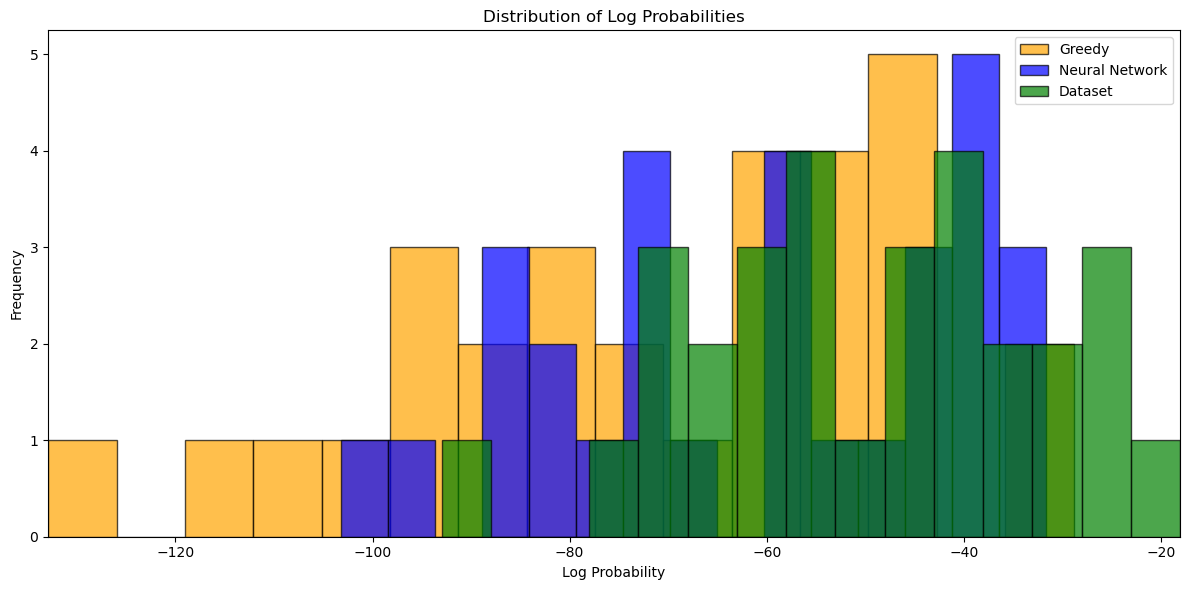

In [ ]:
print("greedy",np.mean(greedy), "random",np.mean(random_vals), "nn", np.mean(nn_vals))

In [60]:
def evaluate_tree_from_dict(tree, prob_dict,parent_label=None):
    applied_rules = []
    log_probs = 0
    if tree.get('children'):
        children = tree['children']
        
        if len(children) == 2:
            chord1 = Chord(children[0]['label'])
            chord2 = Chord(children[1]['label'])
            parent = Chord(tree['label'])
            parent_quality = parent.quality

            if chord1.distance_to(parent) == 0:
                chord1interval = 0
                chord2interval = chord1.distance_to(chord2)
            elif chord2.distance_to(parent) == 0:
                chord1interval = chord2.distance_to(chord1)
                chord2interval = 0
            else:
                # If neither child matches the parent, use distance from parent
                chord1interval = chord1.distance_to(parent)
                chord2interval = chord2.distance_to(parent)

            child_intervals = [str(chord1interval), str(chord2interval)]
            child_qualities = [chord1.quality, chord2.quality]

            rule = Rule(parent_quality, child_intervals, child_qualities)
            applied_rules.append(rule)

        # Recursively gather rules from children
        for child in children:
            applied_rules.extend(evaluate_tree_from_dict(child, prob_dict,tree['label'])[0])

    for rule in applied_rules:
        rule_hash = rule.make_hashable()
        if rule_hash in prob_dict:
            log_probs += np.log(prob_dict[rule_hash])
        else:
            log_probs += np.log(1e-10)
    return applied_rules, log_probs


In [23]:
ccts

[{'label': 'Cm7',
  'children': [{'label': 'Cm7', 'children': []},
   {'label': 'Cm7',
    'children': [{'label': 'Gsus',
      'children': [{'label': 'Fsus',
        'children': [{'label': 'Ebsus',
          'children': [{'label': 'Bbm7', 'children': []},
           {'label': 'Ebsus',
            'children': [{'label': 'Dbsus', 'children': []},
             {'label': 'Ebsus', 'children': []}]}]},
         {'label': 'Fsus', 'children': []}]},
       {'label': 'Gsus', 'children': []}]},
     {'label': 'Cm7',
      'children': [{'label': 'Cm7', 'children': []},
       {'label': 'Cm7',
        'children': [{'label': 'G7',
          'children': [{'label': 'Ab^7',
            'children': [{'label': 'Eb7',
              'children': [{'label': 'Bbm7', 'children': []},
               {'label': 'Eb7', 'children': []}]},
             {'label': 'Ab^7', 'children': []}]},
           {'label': 'G7',
            'children': [{'label': 'D%7', 'children': []},
             {'label': 'G7', 'children': 

In [22]:
def build_tree_from_dict(data):
    """
    Recursively builds a TreeNode-based binary tree from a dictionary with 'label' and 'children'.
    Assumes binary structure: at most two children per node.
    """
    node = TreeNode(Chord(data["label"]))
    
    children = data.get("children", [])
    if len(children) > 0:
        node.left = build_tree_from_dict(children[0])
        node.left.parent = node
    if len(children) > 1:
        node.right = build_tree_from_dict(children[1])
        node.right.parent = node
    # If more than 2 children: silently ignore or raise error
    if len(children) > 2:
        raise ValueError(f"Too many children for binary tree node: {data['label']}")
    
    return node

In [25]:
build_tree_from_dict(ccts[0])  # Example usage with the first tree in ccts

TreeNode(label=Cm7)

In [14]:
tree_chord_data = data[data['trees'].notna()][['chords','trees']]

In [15]:
tree_chord_data['complete_constituent_tree'] = tree_chord_data['trees'].apply(lambda x: x[0]['complete_constituent_tree'])

In [16]:
train_data, test_data = train_test_split(tree_chord_data, test_size=0.2, random_state=42)

In [17]:
test_data_chords = test_data['chords'].tolist()
test_data_trees = test_data['complete_constituent_tree'].tolist()

In [23]:
distances_nn = []
distances_greedy = []
start_nn = []
start_greedy = []
start_test = []

rule_probs = []
rule_probs_greedy = []

for i in range(len(test_data_chords)):
    env = Environment(test_data_chords[i], rules, prob_dict)
    env.add_model(unpickled_model)
    env.nn_simulate()
    rule_probs.append([np.log(prob_dict.get(rule.make_hashable(), 1e-10)) for rule in env.applied_rules])

    env2 = Environment(test_data_chords[i], rules, prob_dict)
    env2.simulate_greedy_baseline()
    rule_probs_greedy.append([np.log(prob_dict.get(rule.make_hashable(), 1e-10)) for rule in env2.applied_rules])
    test_tree = build_tree_from_dict(test_data_trees[i])
    node1 = env.current_nodes[0] 
    node2 = test_tree
    node3 = env2.current_nodes[0]
    distances_nn.append(node1.tree_edit_distance(node2))
    distances_greedy.append(node3.tree_edit_distance(node2))
    start_symbol_nn = env.current_state[0]
    start_symbol_greedy = env2.current_state[0]
    start_symbol_test = test_data_trees[i]['label']
    start_nn.append(start_symbol_nn)
    start_greedy.append(start_symbol_greedy)
    start_test.append(start_symbol_test)

    # Calculate differences between start_nn, start_greedy, and start_test
differences_nn = [1 if start_nn[i] != start_test[i] else 0 for i in range(len(start_nn))]
differences_greedy = [1 if start_greedy[i] != start_test[i] else 0 for i in range(len(start_greedy))]



In [24]:
rule_probs

[[-1.383894222816998,
  -1.383894222816998,
  -1.7002952676177903,
  -1.1197829957910763,
  -1.7002952676177903,
  -5.268888555857225,
  -3.674648234185987,
  -1.7002952676177903,
  -2.858898731533709,
  -2.6588187631152183,
  -1.383894222816998,
  -2.6588187631152183,
  -1.1197829957910763,
  -1.7002952676177903,
  -3.3919712782888625,
  -2.6588187631152183,
  -1.383894222816998,
  -2.772932069882639,
  -1.383894222816998,
  -1.383894222816998,
  -1.383894222816998,
  -1.383894222816998,
  -1.7002952676177903,
  -1.1197829957910763,
  -1.383894222816998,
  -1.1197829957910763,
  -0.8186779030071546,
  -3.674648234185987,
  -1.383894222816998,
  -1.383894222816998,
  -7.545389749611823],
 [-0.8186779030071546,
  -2.772932069882639,
  -1.1197829957910763,
  -2.858898731533709,
  -0.8186779030071546,
  -1.7002952676177903,
  -0.8186779030071546,
  -2.772932069882639,
  -1.383894222816998,
  -6.18517928773138,
  -1.1197829957910763,
  -2.772932069882639,
  -2.959994848405078,
  -0.8186779

In [30]:
start_nn

['Fm6',
 'G7',
 'F7',
 'F7',
 'Fm^7',
 'Cm6',
 'Fm7',
 'G7',
 'Db^7',
 'F7',
 'Bb^7',
 'Db7',
 'Eb7',
 'Ab^7',
 'Dm',
 'F^7',
 'Bb7',
 'G7',
 'C6',
 'G7',
 'E7',
 'Ab^7',
 'Db^7',
 'Dm',
 'Eb7',
 'F7',
 'Em7',
 'G7',
 'Am7',
 'F^7']

In [29]:
start_test

['Fm7',
 'Cm7',
 'Bb6',
 'Ab6',
 'C^7',
 'Cm6',
 'Fm7',
 'C^7',
 'C^',
 'C6',
 'Bb^7',
 'C^7',
 'Ab^7',
 'Ab^7',
 'Dm',
 'F6',
 'Eb6',
 'Cm',
 'C6',
 'C6',
 'Am7',
 'Ab^7',
 'C^7',
 'Dm',
 'Ab^7',
 'Ab6',
 'Em7',
 'C6',
 'Am7',
 'F^7']

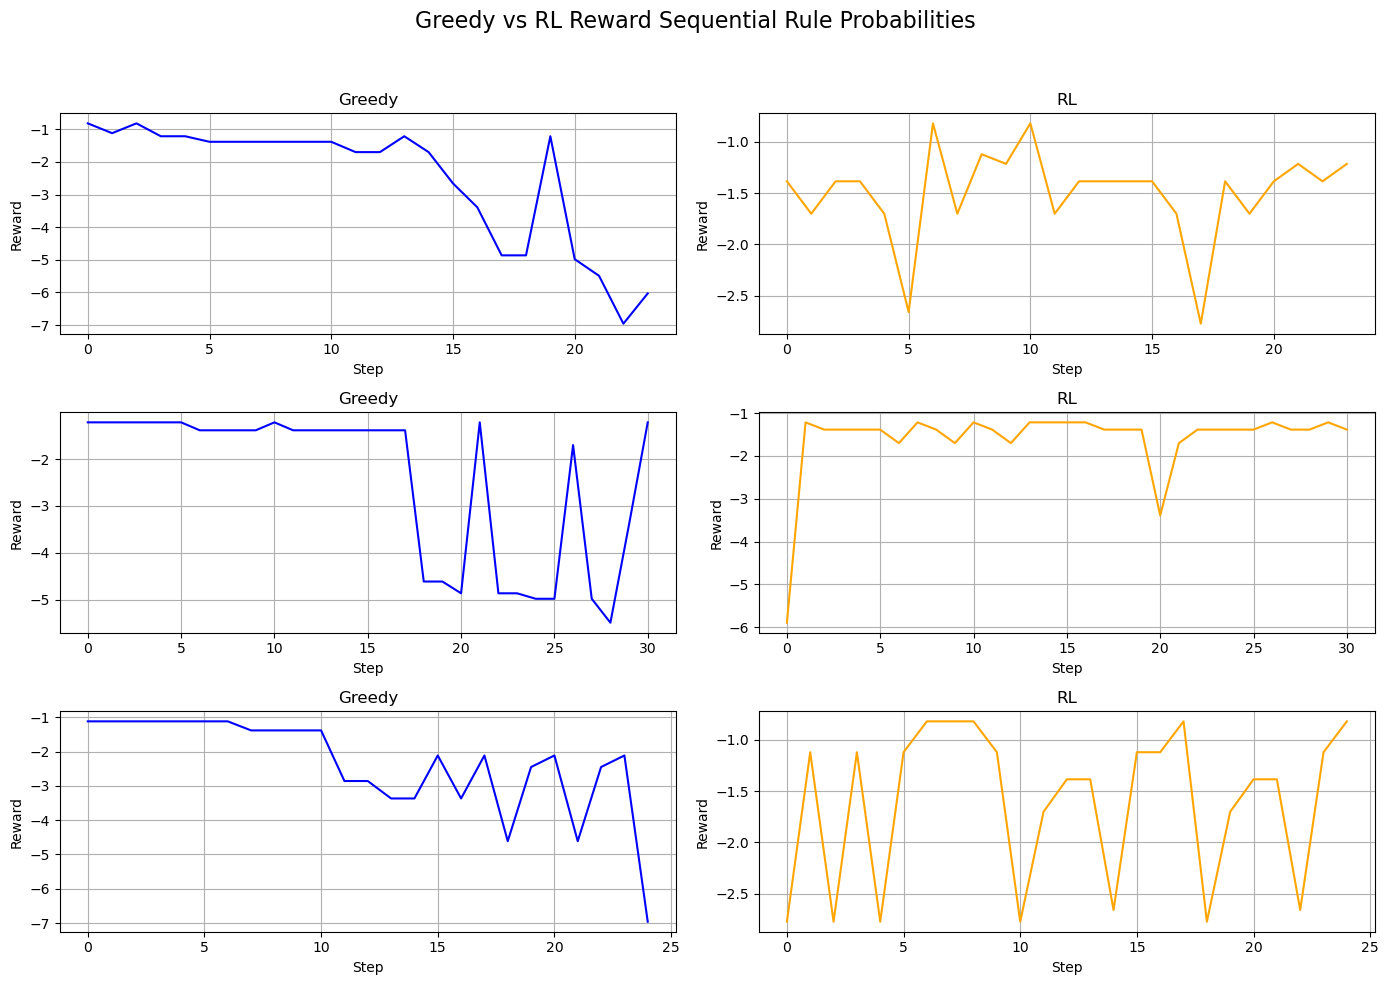

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Flatten the lists if needed
greedy_data = rule_probs_greedy[0] if isinstance(rule_probs_greedy[0][0], list) else rule_probs_greedy
baseline_data = rule_probs[0] if isinstance(rule_probs[0][0], list) else rule_probs

# Ensure both have the same number of sequences
num_sequences = min(len(greedy_data), len(baseline_data))

# Compute average reward for each RL sequence
avg_rewards = [np.mean(seq) for seq in baseline_data]

# Get the indices of the top 3 sequences with highest average reward
top_indices = sorted(range(len(avg_rewards)), key=lambda i: avg_rewards[i], reverse=True)[:3]

# Use these indices to get matching sequences
greedy_seqs = [greedy_data[i] for i in top_indices]
baseline_seqs = [baseline_data[i] for i in top_indices]

# Create 3x2 subplots (3 rows, 2 columns)
fig, axes = plt.subplots(3, 2, figsize=(14, 10), sharex=False)

# Plot sequences side by side in each row
for i in range(3):
    axes[i, 0].plot(greedy_seqs[i], color='blue')
    axes[i, 0].set_title('Greedy')
    axes[i, 0].set_ylabel('Reward')
    axes[i, 0].set_xlabel('Step')  # Add x-axis label
    axes[i, 0].grid(True)

    axes[i, 1].plot(baseline_seqs[i], color='orange')
    axes[i, 1].set_title('RL')
    axes[i, 1].set_ylabel('Reward')
    axes[i, 1].set_xlabel('Step')  # Add x-axis label
    axes[i, 1].grid(True)

plt.suptitle("Greedy vs RL Reward Sequential Rule Probabilities", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [85]:
sum(differences_nn)

19

In [83]:
sum(differences_greedy)

26

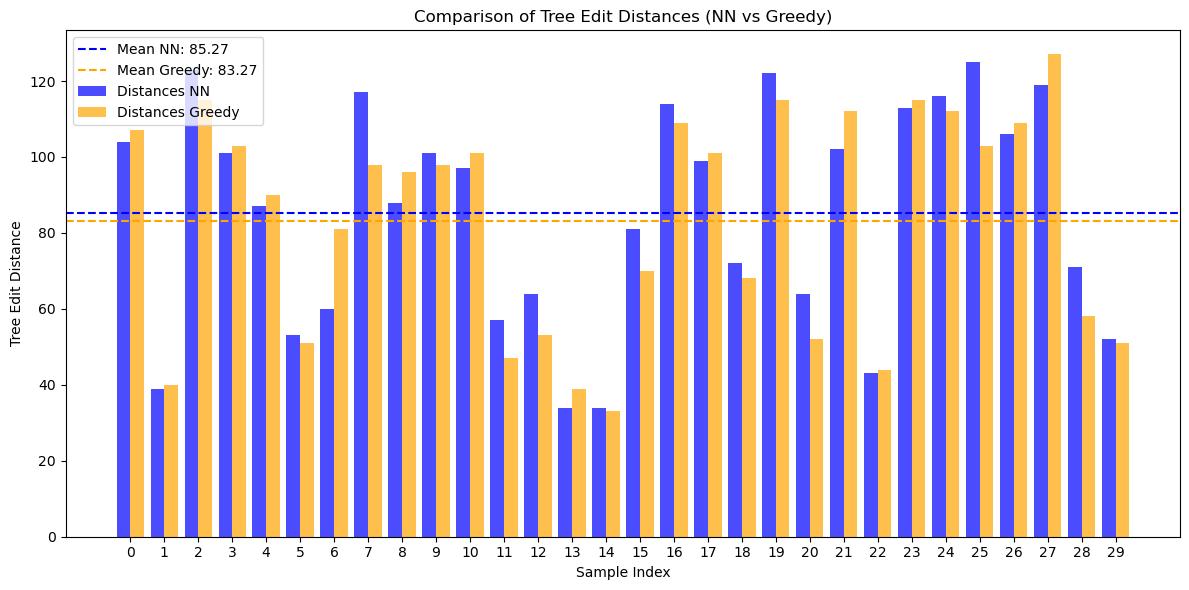

In [76]:
import numpy as np
import matplotlib.pyplot as plt

# Create an array of indices for the x-axis
indices = np.arange(len(distances_nn))

plt.figure(figsize=(12, 6))

# Define the width of each bar
bar_width = 0.4

# Plot the bars for distances_nn and distances_greedy
plt.bar(indices - bar_width / 2, distances_nn, width=bar_width, label='Distances NN', color='blue', alpha=0.7)
plt.bar(indices + bar_width / 2, distances_greedy, width=bar_width, label='Distances Greedy', color='orange', alpha=0.7)

# Plot the mean lines
mean_nn = np.mean(distances_nn)
mean_greedy = np.mean(distances_greedy)
plt.axhline(y=mean_nn, color='blue', linestyle='--', label=f'Mean NN: {mean_nn:.2f}')
plt.axhline(y=mean_greedy, color='orange', linestyle='--', label=f'Mean Greedy: {mean_greedy:.2f}')

# Add labels, title, and legend
plt.xlabel('Sample Index')
plt.ylabel('Tree Edit Distance')
plt.title('Comparison of Tree Edit Distances (NN vs Greedy)')
plt.xticks(indices)  # Set x-axis ticks to match the indices
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()